In [27]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import networkx as nx
import time

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

#Função auxiliar para definir se o robô está perto o suficiente de um ponto ou não
def estaPerto(xRobo, yRobo, xPonto, yPonto, dist_tresh = .09):
    dist = np.sqrt((xRobo - xPonto)**2 + (yRobo - yPonto)**2)
    return dist <= dist_tresh

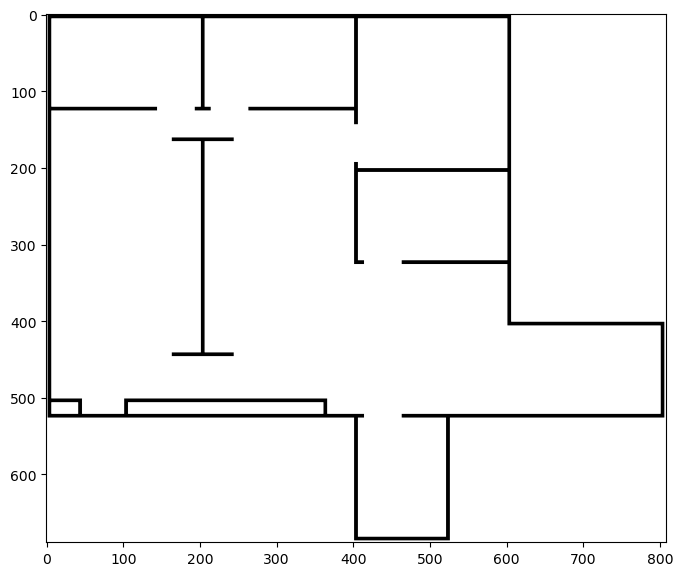

In [28]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

img = 1 - mpimg.imread('autolab.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')
shape = np.array([img.shape[0], img.shape[1]])

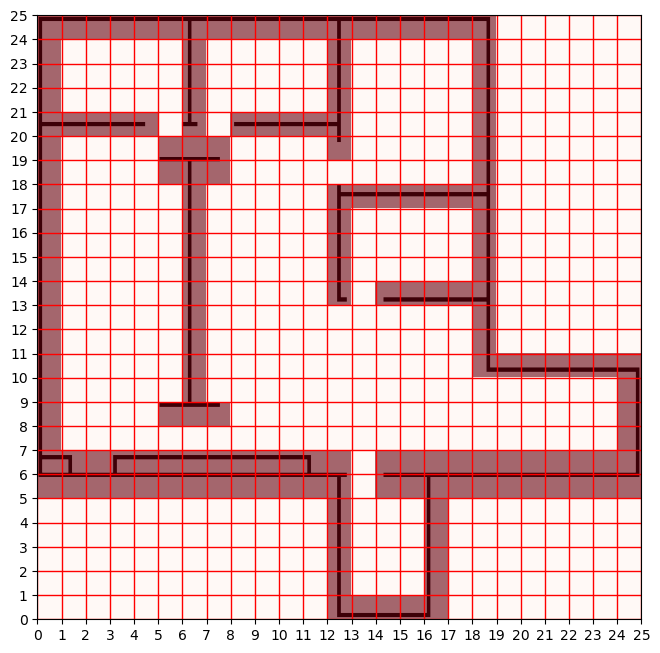

In [58]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([25, 25]) 
# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 1

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

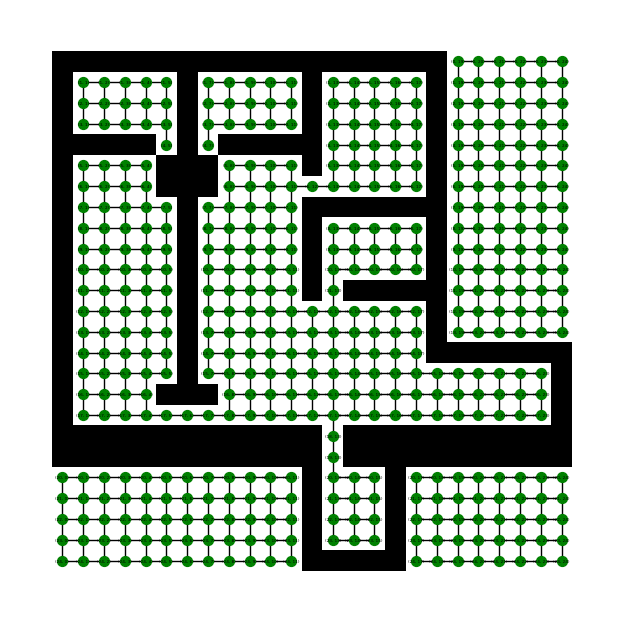

In [59]:
# Criando o Grafo para o nosso Grid

# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

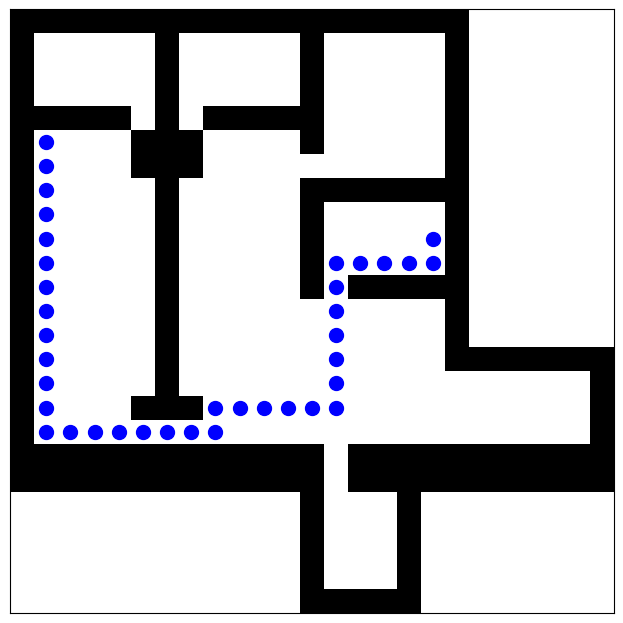

In [76]:
# Finalmente podemos determinar o menor caminho entre duas células
# ATENÇÃO para o Sistema de Coordenadas -- relação Índice do grid e Posição no mundo

start_node = (5, 1)
end_node = (9, 17)

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=100, node_color='b')

In [78]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    robotname = 'robotino'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    
    #Definindo e setando o robô na posição inicial
    posInicial = np.array([1, -5, .01])
    returnCode = sim.simxSetObjectPosition(clientID, robotHandle, -1, posInicial, sim.simx_opmode_oneshot_wait)
                 
    returnCode, wheel1 = sim.simxGetObjectHandle(clientID, 'wheel0_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel2 = sim.simxGetObjectHandle(clientID, 'wheel1_joint', sim.simx_opmode_oneshot_wait)
    returnCode, wheel3 = sim.simxGetObjectHandle(clientID, 'wheel2_joint', sim.simx_opmode_oneshot_wait)
    
    #Definição de um frame auxiliar
    referencia = 'ReferenceFrame0'
    returnCode, refHandle = sim.simxGetObjectHandle(clientID, referencia, sim.simx_opmode_oneshot_wait)
           
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
                       
    q = np.array([0, 0, 0])
    returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    #A posição (x,y) do robô na CENA tem x variando de 0 até aprox. 35 e y de 0 até aprox. -35.
    #Pego o valor de y invertido para que fique positivo e combine com os valores do roadmap
    pos = np.array([posRobot[0], -posRobot[1]])
    
    b = 1

    for ponto in path:
        
        returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        pos = np.array([posRobot[0], -posRobot[1]])
        #Cada ponto do path é da forma (y,x), então inverto
        ponto = np.array([ponto[1], ponto[0]])
        
        #Seto o frame auxiliar no ponto que o robô deve alcançar
        setRef = np.array([ponto[0], -ponto[1], .01])
        #Verifico a posição desse frame em relação ao robô
        returnCode = sim.simxSetObjectPosition(clientID, refHandle, -1, setRef, sim.simx_opmode_oneshot_wait)
        returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
        
        #Se o frame está muito para esquerda no referencial do robô, então deve virar para a esquerda
        if posRef[1] > .5:
            sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_streaming)
            while b:
                returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
                returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
                if posRef[1] <= -.01:
                    break
                qdot = np.array([0, 0, np.deg2rad(5)])
                Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
                u = Minv @ qdot
                sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
          
        #Se o frame está muito para direita no referencial do robô, então deve virar para a direita
        elif posRef[1] < -.5:
            sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_streaming)
            sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_streaming)
            while b:
                returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
                returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
                if posRef[1] >= .01:
                    break
                qdot = np.array([0, 0, np.deg2rad(-5)])
                Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
                u = Minv @ qdot
                sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
        
        #Enquanto não me aproximei o suficiente do ponto, mantendo em linha reta
        while not estaPerto(pos[0], pos[1], ponto[0], ponto[1]):
            qdot = np.array([.08, 0, 0])
            Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
            u = Minv @ qdot
            sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_oneshot_wait)
            returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
            
            #Aplico a mesma ideia de definir os momentos de virar para fazer pequenas correções na rota
            if posRef[1] > .05:
                sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_streaming)
                while b:
                    returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
                    returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
                    if posRef[1] <= 0:
                        break
                    qdot = np.array([0, 0, np.deg2rad(5)])
                    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
                    u = Minv @ qdot
                    sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
                    sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
                    sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
                
            elif posRef[1] < -.05:
                sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_streaming)
                sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_streaming)
                while b:
                    returnCode, posRobot = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
                    returnCode, posRef = sim.simxGetObjectPosition(clientID, refHandle, robotHandle, sim.simx_opmode_oneshot_wait)
                    if posRef[1] >= 0:
                        break
                    qdot = np.array([0, 0, np.deg2rad(-5)])
                    Minv = np.linalg.inv(Rz(q[2]) @ Mdir)
                    u = Minv @ qdot
                    sim.simxSetJointTargetVelocity(clientID, wheel1, u[0], sim.simx_opmode_streaming)
                    sim.simxSetJointTargetVelocity(clientID, wheel2, u[1], sim.simx_opmode_streaming)
                    sim.simxSetJointTargetVelocity(clientID, wheel3, u[2], sim.simx_opmode_streaming)
                
            pos = np.array([posRobot[0], -posRobot[1]])
                                
    sim.simxSetJointTargetVelocity(clientID, wheel1, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel2, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, wheel3, 0, sim.simx_opmode_oneshot_wait)   
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Connected to remote API server
Program ended
